/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


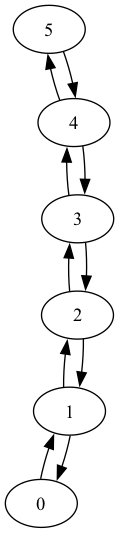

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

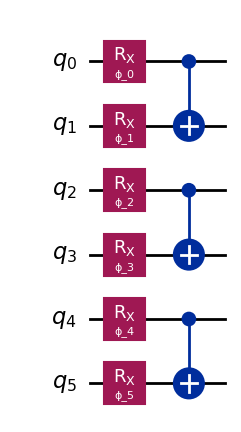

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


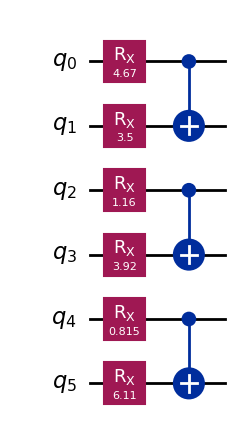

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

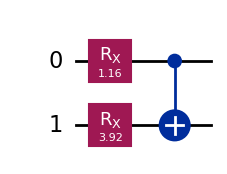

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

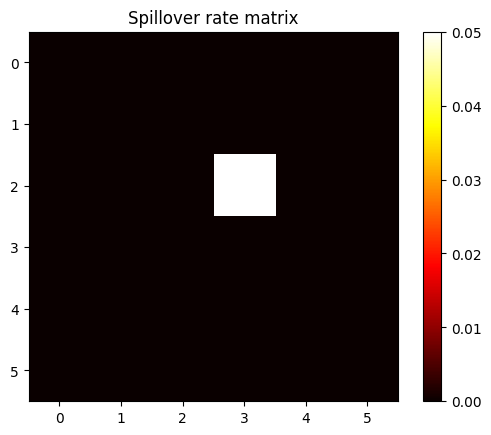

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.05  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.0 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

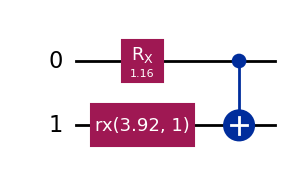

In [7]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [9]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.1607433119572852]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [10]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '43cb62ad46f34544bff7db60ace25932',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99957899+0.j        , 0.        -0.02901451j],
              [0.        -0.02901451j, 0.99957899+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [12]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [13]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x152017f90>,

In [14]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [15]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '43cb62ad46f34544bff7db60ace25932',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99957899+0.j        , 0.        -0.02901451j],
              [0.        -0.02901451j, 0.99957899+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [16]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


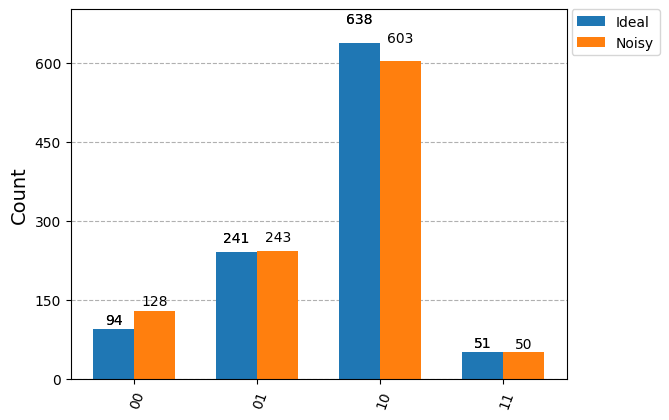

In [17]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [18]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [19]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9993265265528055

In [20]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


# def apply_parametrized_circuit(
#     qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
# ):
#     """
#     Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
#     This function is used to run the QuantumCircuit instance on a Runtime backend
#     :param qc: Quantum Circuit instance to add the gate on
#     :param params: Parameters of the custom Gate
#     :param q_reg: Quantum Register formed of target qubits
#     :return:
#     """
#     target = kwargs["target"]
#     my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
#     optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
#     # optimal_params = np.pi * np.zeros(len(params))
#     new_params = [optimal_params[i] + params[i] for i in range(len(params))]

#     my_qc.u(
#         new_params[0],
#         -np.pi/2,
#         np.pi/2,
#         q_reg[0],
#     )
#     my_qc.u(
#         0.,
#         new_params[1],
#         new_params[2],
#         q_reg[0],
#     )
#     my_qc.u(
#         *new_params[3:6],
#         q_reg[1],
#     )

#     my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

#     qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [21]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.2, high=0.2, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[5,],
        n_shots=100,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

In [22]:
import numpy as np
from typing import Optional, Dict, Any, SupportsFloat
from qiskit import QuantumCircuit
from rl_qoc.environment.context_aware_quantum_environment import (
    ObsType,
    ActType,
    ContextAwareQuantumEnvironment,
)
from gymnasium.spaces import Box
from rl_qoc import ContextAwareQuantumEnvironment, QEnvConfig, GateTarget
from spillover_effect_on_subsystem import (
    noisy_backend,
    circuit_context,
    LocalSpilloverNoiseAerPass,
    numpy_to_hashable,
)
from rl_qoc.helpers import causal_cone_circuit
import itertools

class GeneralAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params: int,
        discrete_history_length: int,
        applied_qubits: list,  # list of qubits which we will include the effect of
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
        obs_bounds: Optional[tuple] = (-np.pi, np.pi),
    ):
        """
        Initialize the environment
        """
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters
        self.num_qubits = len(applied_qubits)  # Number of qubits

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-1.0] * len(applied_qubits)),
            high=np.array([1.0] * len(applied_qubits)),
            dtype=np.float64,
        )
        self.obs_bounds = obs_bounds

        # Define discrete observation values for a single qubit
        self.single_qubit_discrete_obs_vals_raw = np.linspace(
            self.observation_space.low[0], self.observation_space.high[0], self.num_params
        )
        # Generate all possible combinations for N qubits
        self.discrete_obs_vals_raw = np.array(
            list(itertools.product(self.single_qubit_discrete_obs_vals_raw, repeat=self.num_qubits))
        )
        self.discrete_obs_vals_angles = self.obs_raw_to_angles(self.discrete_obs_vals_raw)
        print(f"Observation Vals for Agent: {self.discrete_obs_vals_raw}")
        print(f"Observation Vals for Env: {self.discrete_obs_vals_angles}")

        # Initialize reward history and probability weights for all possible combinations
        self.discrete_reward_history = np.ones(
            (discrete_history_length, len(self.discrete_obs_vals_raw))
        )
        self.prob_weights = np.ones(len(self.discrete_obs_vals_raw))
        self.prob_weights /= len(self.prob_weights)

        self.obs_angles = np.zeros(self.observation_space.shape)
        self.applied_qubits = applied_qubits
        self.obs_raw = np.zeros(self.observation_space.shape)

    def obs_raw_to_angles(self, obs_raw):
        # Obs raw between -1. and 1.
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2
        obs_scaled = obs_raw * scale
        angles = obs_scaled + mean
        return angles

    def angles_to_obs_raw(self, angles):
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        # Obs raw between -1. and 1.
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2
        obs_scaled = angles - mean
        obs_raw = obs_scaled / scale
        return obs_raw

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        """
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
            self.obs_raw = self.angles_to_obs_raw(self.obs_angles)
        else:
            self.obs_raw = self._get_new_obs_raw()
            self.obs_angles = self.obs_raw_to_angles(self.obs_raw)

        self.phi_vec = np.zeros(self.unbound_circuit_context.num_qubits)
        self.phi_vec[self.applied_qubits] = self.obs_angles

        param_dict = {self.circuit_parameters[i].name: self.phi_vec[i] for i in range(len(self.phi_vec))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", self.phi_vec)
        print(f"Environment Observation: {env_obs}")
        return env_obs, {}

    def _get_new_obs_raw(self):
        if self.circuit_param_distribution == "uniform":
            obs_raw = np.random.uniform(
                self.observation_space.low,
                self.observation_space.high,
                self.observation_space.shape,
            )
        elif self.circuit_param_distribution == "simple_discrete":
            # Sample each qubit's observation independently
            obs_raw = np.random.choice(
                a=self.single_qubit_discrete_obs_vals_raw,
                size=self.observation_space.shape[0],
                replace=True,
            )
        elif self.circuit_param_distribution == "moving_discrete":
            # Update probability weights based on reward history
            self.prob_weights = (
                np.mean(self.discrete_reward_history, axis=0)
                + np.log10(self.optimal_error_precision)
            ) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            # Sample an index from all possible combinations
            idx = np.random.choice(
                len(self.discrete_obs_vals_raw),
                p=self.prob_weights,
            )
            obs_raw = self.discrete_obs_vals_raw[idx]
        return obs_raw

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        print(f"batch action shape: {action.shape}")
        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        if self.circuit_param_distribution == "moving_discrete":
            self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info

    def update_discrete_history(self, reward, obs):
        # Find the index of the closest discrete observation value
        obs_ind = np.argmin(np.sum((self.discrete_obs_vals_raw - obs) ** 2, axis=1))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )

    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        """
        return self.obs_raw

    def _get_info(self) -> Any:
        return {}

In [23]:
# Constructing general angle spillover env

# from general_angle_spillover_env import GeneralAngleSpilloverEnv

general_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1. ]
 [-0.5]
 [ 0. ]
 [ 0.5]
 [ 1. ]]
Observation Vals for Env: [[0.        ]
 [0.78539816]
 [1.57079633]
 [2.35619449]
 [3.14159265]]


In [24]:
rescaled_general_env = RescaleAndClipAction(general_env, min_action=-1., max_action=1.)

In [25]:
_, _ = general_env.reset(
    debug_obs=np.array([np.pi])
)

Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]


Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551


Reward (avg): 0.9950368054724947 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.8828187526945435 Std: 0.0
Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.6579098898241216 Std: 0.0
Number of repetitions: 13
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.3881157080794121 Std: 0.0
Number of repetitions: 17
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9950753362380551
Reward (avg): 0.22986025515664515 Std: 0.0
Found parameters: [1.61489349e-01 7.60301809e-11], in radians: [0.0514 0.    ]


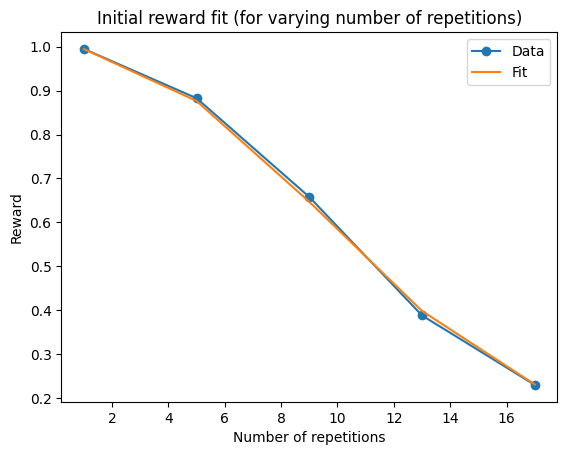

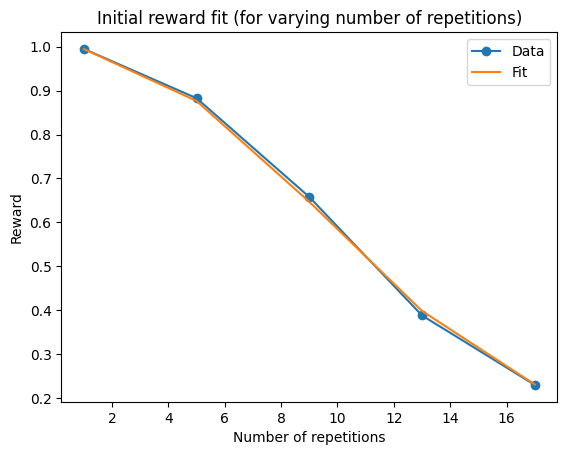

In [27]:
general_env.initial_reward_fit(
    np.zeros((1, 7)),
    # opt_action,
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 21, 4),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="channel",
    # fit_p0=list(subsystem_spillover_angles)
)

In [26]:
train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1. ]
 [-0.5]
 [ 0. ]
 [ 0.5]
 [ 1. ]]
Observation Vals for Env: [[0.        ]
 [0.78539816]
 [1.57079633]
 [2.35619449]
 [3.14159265]]


In [27]:
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)

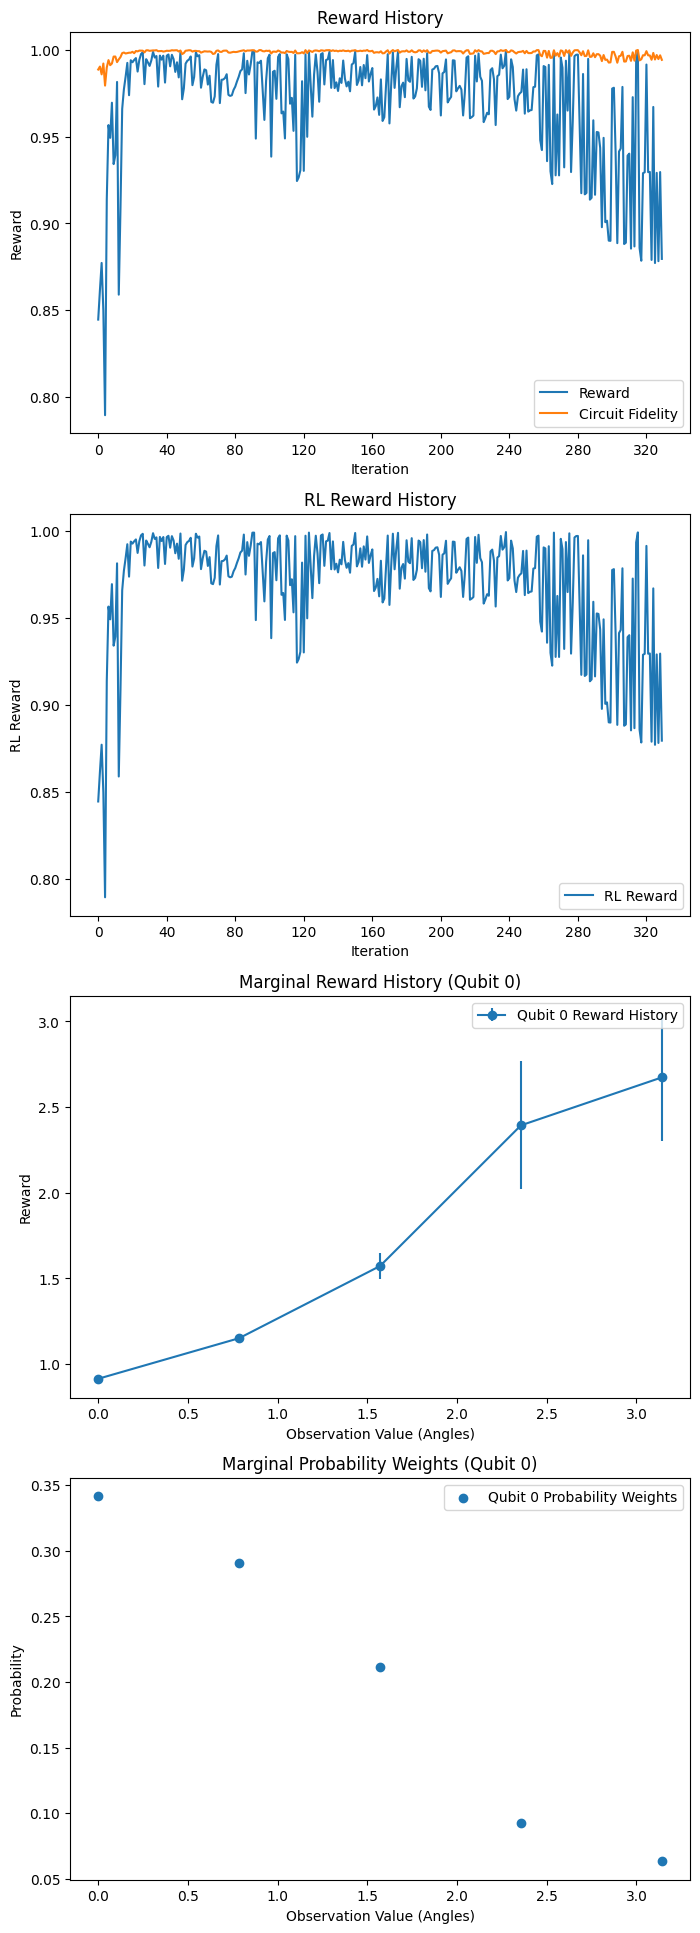

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.994459354751382
Reward (avg): 0.8700258741196634 Std: 0.0009858720521836817
obs: [-1.]
reward: [0.88684589 0.88589255 0.88164915 0.88569802 0.88174255 0.89145596
 0.88066417 0.88527735 0.89021136 0.88756221 0.89041396 0.8827674
 0.8850821  0.88518944 0.88260972 0.89446933 0.88315231 0.88667473
 0.88687974 0.8862923  0.88727899 0.88504734 0.88651772 0.88387058
 0.89189663 0.89145732 0.88603477 0.88649924 0.88248718 0.88675303
 0.88727442 0.88133239]


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [-0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9968840619154522
Reward (avg): 0.9255663706687984 Std: 0.0007094865197040148
obs: [-0.5]
reward: [1.12508985 1.12374274 1.13244035 1.13160116 1.12747504 1.13106285
 1.12857023 1.12444267 1.12115739 1.12688807 1.12691026 1.13404784
 1.11896637 1.1286683  1.12907144 1.1326557  1.13510071 1.13086293
 1.13097427 1.12707882 1.12972664 1.13106593 1.1198084  1.1284487
 1.13368125 1.13472764 1.12353447 1.13076051 1.12863821 1.12597115
 1.12696757 1.123878  ]


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...


{'avg_reward': [0.8445813131856525,
  0.8615273570669965,
  0.8772222303101037,
  0.8497566681082489,
  0.7894961716954322,
  0.9139320160725016,
  0.9566589429660062,
  0.9493108983450502,
  0.9695420116379485,
  0.934178477007914,
  0.939357162933553,
  0.9815124511562177,
  0.8589502085474076,
  0.9087943693602438,
  0.9659945378442929,
  0.9773115338551406,
  0.9845390756674723,
  0.9924973798631982,
  0.9738635254257723,
  0.994016120626529,
  0.992842168476541,
  0.9942014875753659,
  0.99525428139947,
  0.9875012300189171,
  0.9942483230339942,
  0.9976027499667501,
  0.9984881454756218,
  0.9802500309867166,
  0.9946358264208318,
  0.9927676863438133,
  0.9907476276944905,
  0.9938978529452422,
  0.9988434810792727,
  0.9955782215782638,
  0.9964290854183198,
  0.9788427489793541,
  0.9967046095141379,
  0.9943694252019538,
  0.9966361973578837,
  0.9811462202845734,
  0.9966105318943642,
  0.9973400549369732,
  0.9905189515245849,
  0.9971430264421404,
  0.994655008175601,
  0

<Figure size 640x480 with 0 Axes>

In [28]:
from rl_qoc.agent import PPOConfig

agent_config = PPOConfig.from_yaml("alt_agent_config.yaml")
print(agent_config)

from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_q_env, save_data=False)
total_updates = 1600
target_fidelities = [0.9999]
lookback_window = 10
anneal_learning_rate = True

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)

train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

In [29]:
NUM_EVAL = 7
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]


AttributeError: 'Agent' object has no attribute 'get_action_and_value'

In [32]:
(ppo_agent.unwrapped_env.total_shots)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
